In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np

from google.colab import drive
drive.mount('/content/drive')

!cp "drive/My Drive/tools.py" .
from tools import *

!unzip "drive/My Drive/data.zip"

# Partie 1 : SIFT

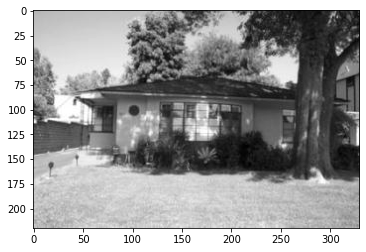

In [ ]:
# example images
I = read_grayscale('data/tools.tiff')
I2 = read_grayscale('data/Scene/CALsuburb/image_0205.jpg')
plt.imshow(I2)

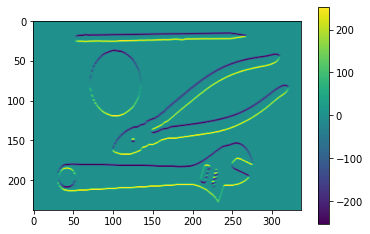

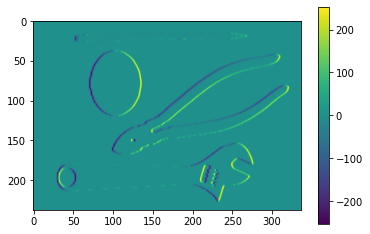

In [ ]:
def compute_grad(I):
    hx = np.array([-1,0,1]) * 0.5
    hy = np.array([1,2,1]) * 0.5
    Ix = conv_separable(I,hy,hx)
    Iy = conv_separable(I,hx,hy)
    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()
# On observe que le gradient est élevé au niveau des contours et coins de l'image

In [ ]:
def compute_grad_mod_ori(I):
    Ix, Iy = compute_grad(I)
    Gn = np.sqrt((Ix**2 + Iy**2))
    Go = compute_grad_ori(Ix,Iy,Gn)
    return Gn, Go

gn, go = compute_grad_mod_ori(I2)

(128,)


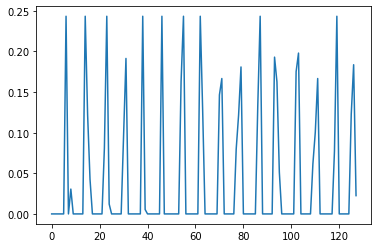

In [ ]:
def compute_sift_region(Gn, Go, mask=None):
    Gn_pond = Gn
    P = []
    # Note: to apply the mask only when given, do:
    if mask is not None:
        Gn_pond = Gn * mask
    for i in range(0, 16, 4):
        for j in range(0, 16, 4):
            region_o = Go[i:i+4, j:j+4]
            region_n = Gn_pond[i:i+4, j:j+4]
            
            for k in range(8):
                R = region_n[ np.where(region_o == k)].sum()
                P.append(R)
            
    # Post-processing
    
    if np.linalg.norm(P) < 0.5:
        return np.zeros(len(P))
    else:
        P /= np.linalg.norm(P)
        sift = np.where(P>0.2, 0.2, P)
        sift /= np.linalg.norm(sift)
    
    return sift

sift = compute_sift_region(gn, go, True)
print(sift.shape)
plt.plot(sift)

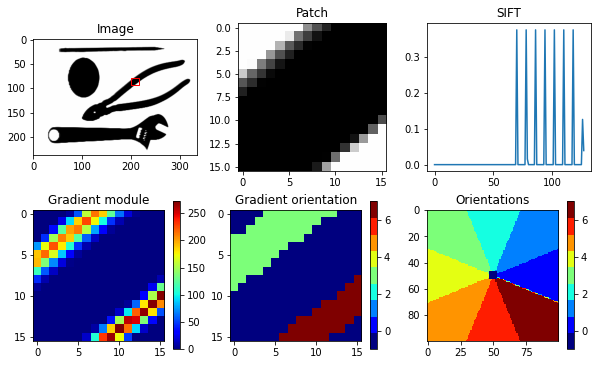

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.37462778, 0.        , 0.        , 0.        , 0.     

In [ ]:
display_sift_region(I, compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
# display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
# display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
# display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
# display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [ ]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    gn, go = compute_grad_mod_ori(I)
    # TODO calculs communs aux patchs
    sifts = np.zeros((len(x), len(y), 128))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            sifts[i, j, :] = compute_sift_region( gn[xi:xi+16, yj:yj+16], go[xi:xi+16, yj:yj+16] )
    return sifts

sift_images = compute_sift_image(I2)
print(sift_images.shape)

(28, 42, 128)


# Partie 2 : Dictionnaire visuel

In [ ]:
# Ideally, restart the Python kernel to start from a clean slate
import os
import numpy as np
!cp "drive/My Drive/sift.py" .
from tools import *
from sift import *
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [ ]:
# Paths config
dir_sc = os.path.join('data', 'Scene')
dir_sift = os.path.join('data', 'sift')
path_vdict = os.path.join('data', 'kmeans', 'vdict.npy')
path_vdsift = os.path.join('data', 'kmeans', 'vdsift.npy')
path_vdinames = os.path.join('data', 'kmeans', 'vdinames.npy')

inames, ilabls, cnames = load_dataset(dir_sc)

In [ ]:
# If you want to look at the SIFTs that will be fed to compute_visual_dict:
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs


In [ ]:
type(sifts_list_by_image[0])

numpy.ndarray

In [ ]:
# Code here the `compute_visual_dict` function
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]
    
    # TODO compute kmeans on `sift`, get cluster centers, add zeros vector
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, verbose=verbose)
    kmeans.fit(sift)
    clusters = kmeans.cluster_centers_
    v = np.zeros((1, 128))
    res = np.concatenate((clusters, v), axis=0)
    
    return res

In [ ]:
# Run the visual dict computation (saved the first time)
vdict = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)
type(vdict)
print(vdict.shape)

In [ ]:

vdict = np.load("drive/My Drive/vdict.npy")

()


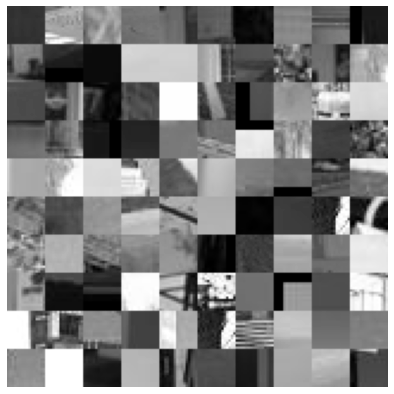

(31912, 16, 16) (31912, 128)


In [ ]:
# Study of the dict
regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 30)) # Compute SIFT and regions from 30 random images
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

# TODO visually analyze the dict through similar example regions
#
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center

print(regions.shape, sifts.shape)

In [ ]:
## In order to get "vdregions", we are gonna compute the distance between each sifts descriptor and the clusters
## But first of all, we need to normalize our visual dictionnary to get significant results

for i in range(len(vdict)):
  norme = np.linalg.norm(vdict[i,:])
  if norme != 0: # to avoid division by zero
    vdict[i,:] /= norme

dist = cdist(vdict,sifts,metric='euclidean') # (1001, 31304)
closest = np.argmin(dist, 1) # (1001,)
vdregions = regions[closest]


(1001, 16, 16)

In [ ]:
regions.shape

(28, 42, 16, 16)

# Partie 3 : BoW

In [ ]:
# Compute BoW for an image
from scipy.spatial.distance import euclidean

def compute_feats(vdict, image_sifts):
    # TODO compute BoW from `image_sifts`
    images = image_sifts.reshape(-1,image_sifts.shape[2]) # 3d -> 2d
    n,d = images.shape
    m,d = vdict.shape
    H = []
    
    # Coding step
    for i in range(n):
        dist = np.zeros(m)
        for k in range(m):
            dist[k] = euclidean(images[i], vdict[k])
        h = np.zeros(m)
        h[np.argmin(dist)] = 1
        H.append(h)
         
    # Pooling step
    z = np.sum(H,axis=0)
    
    print(z.shape)

    # Normalisation L2
    z /= np.linalg.norm(z)
    
    return z

In [ ]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
regions = compute_regions(im)
feats = compute_feats(vdict, sift)


display_vdregions_image(im, vdict, sift, feats, vdregions=vdregions) # if you have vdregions, add it as input here

# Partie 4 : SVM

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd

1. Préparer / charger la matrice X et le vecteur y de features et labels

In [ ]:
data = np.load("15_scenes_Xy.npz", "rb")
X = data["X"]
y = data["y"]
print(X.shape)

2. Séparer vos données en des ensemble de train / val / test avec 70% / 10% / 20% des données. Utilisez la fonction compute_split .

In [ ]:
train_ids, ids = compute_split(X.shape[0], pc=0.7)
val_ids, test_ids = compute_split(len(ids), pc=1/3)

print(train_ids.shape, test_ids.shape, val_ids.shape)

X_train, y_train = X[train_ids], y[train_ids]
X_test, y_test = X[test_ids], y[test_ids]
X_val, y_val = X[val_ids], y[val_ids]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(3139,) (898,) (448,)
(3139, 1001) (3139,) (898, 1001) (898,) (448, 1001) (448,)


3. Apprendre un SVM (utilisez scikit-learn) sur vos données de train avec différentes valeurs de C ("équivalent" au $\lambda$ ci-dessus). Commencez par C = 1 pour tester avant d'en apprendre d'autres.

In [ ]:
C = [0.001, 0.01, 0.1, 1, 10]
score_test = []
score_train = []
score_val = []
for c in C: 
    clf = OneVsRestClassifier( LinearSVC(C = c) ).fit(X_train, y_train)
    
    pred_test = clf.predict(X_test)
    score_test.append(np.where(pred_test==y_test, 1, 0).mean())
    
    pred_train = clf.predict(X_train)
    score_train.append(np.where(pred_train==y_train, 1, 0).mean())
    
    pred_val = clf.predict(X_val)
    score_val.append(np.where(pred_val==y_val, 1, 0).mean())

4. Evaluez vos SVM sur l'ensemble de validation/train/test pour trouver la valeur optimale de C.

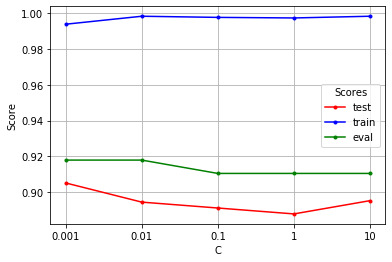

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots()
axs.plot(score_test, 'r.-', label = "test")
axs.plot(score_train, 'b.-', label = "train")
axs.plot(score_val, 'g.-', label = "eval")
axs.xaxis.set_ticks(range(5))
axs.xaxis.set_ticklabels(C)
axs.set_xlabel('C')
axs.set_ylabel('Score')
axs.grid(True)

plt.legend(title = "Scores")
plt.show()